# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Environment Setting

In [2]:
env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)

UNKNOWN  = CONST.UNKNOWN # -1
TEAM1_BG = CONST.TEAM1_BACKGROUND # 0
TEAM2_BG = CONST.TEAM2_BACKGROUND # 1
TEAM1_AG = CONST.TEAM1_UGV # 2
TEAM2_AG = CONST.TEAM2_UGV # 4
TEAM1_FL = CONST.TEAM1_FLAG # 6
TEAM2_FL = CONST.TEAM2_FLAG # 7
OBSTACLE = CONST.OBSTACLE # 8
DEAD     = CONST.DEAD # 9
SELECTED = CONST.SELECTED # 10
COMPLETED= CONST.COMPLETED # 11

VISION_RANGE = CONST.UGV_RANGE
VISION_dX    = 2*VISION_RANGE+1
VISION_dY    = 2*VISION_RANGE+1

In [3]:
print('red number : ', len(env.get_team_red))
print('blue number : ', len(env.get_team_blue))
print('vision range : ', VISION_RANGE)

red number :  0
blue number :  4
vision range :  10


## Discount Reward

In [4]:
gamma = 0.98

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for t in reversed(range(r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def discount_rewards_multiagent(r, n_agents):
    discounted_r = np.reshape(r,(-1,n_agents)) # Reshape the r into vertical matrix with 'n_agents' columns
    for idx in range(n_agents):
        column = discounted_r[:,idx]                     # extract single column
        discounted_r[:,idx] = discount_rewards(column);  # Run discount_reward on the column, and substitute
    return np.reshape(discounted_r,(-1))                 # return the flattened matrix

## Network Setting

In [5]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        layer = slim.conv2d(self.state_input, 64, [5,5],# activation_fn=tf.nn.relu,
                            padding='VALID',
                            scope='conv1')
        layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 64, [3,3],# activation_fn=tf.nn.relu,
                            padding='VALID',
                            scope='conv2')
        layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 128, [2,2],# activation_fn=tf.nn.relu,
                            padding='VALID',
                            scope='conv3')
        layer = slim.flatten(layer)
        #flat  = tf.reshape(conv, [-1, VISION_dX*VISION_dY*128])
        
        layer = slim.dropout(layer,keep_prob=0.85)
        dense = slim.fully_connected(layer, action_size,
                                            #activation_fn=tf.nn.relu,
                                            biases_initializer=None)
        self.output = tf.nn.softmax(dense, name='action')
        #self.chosen_action = tf.argmax(self.output,1, name='action')

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.

        with tf.name_scope('Writer'):
            self.mean_reward = tf.placeholder("float", None)
            self.mean_length = tf.placeholder("float", None)
            self.mean_succeed = tf.placeholder("float", None)
            self.exploration = tf.placeholder("float",None)
            tf.summary.scalar('mean_reward', self.mean_reward)
            tf.summary.scalar('mean_length', self.mean_length)
            tf.summary.scalar('mean_succeed', self.mean_succeed)
            tf.summary.scalar('exploration', self.exploration)
    
        with tf.name_scope('action'):
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
            self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder

        with tf.name_scope('loss'):
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)
            self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)

        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        with tf.name_scope('gradients'):
            self.gradients = tf.gradients(self.loss,tvars)

        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [6]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=1e-4,in_size=[None,VISION_dX,VISION_dY,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

/home/namsong/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Hyperparameters

In [7]:
total_episodes = 102000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5
save_network_frequency = 100
save_reward_frequency = 10

## One-hot Encoder

In [8]:
def one_hot_encoder(state, agents):
    ret = np.zeros((len(agents),VISION_dX,VISION_dY,6))
    # team 1 : (1), team 2 : (-1), map elements: (0)
    map_channel = {UNKNOWN:0, DEAD:0,
                   TEAM1_BG:1, TEAM2_BG:1,
                   TEAM1_AG:2, TEAM2_AG:2,
                   3:3, 5:3, # UAV, does not need to be included for now
                   TEAM1_FL:4, TEAM2_FL:4,
                   OBSTACLE:5}
    map_color   = {UNKNOWN:0, DEAD:0, OBSTACLE:0,
                   TEAM1_BG:1, TEAM2_BG:-1,
                   TEAM1_AG:1, TEAM2_AG:-1,
                   3:1, 5:-1, # UAV, does not need to be included for now
                   TEAM1_FL:1, TEAM2_FL:-1}
    
    # Expand the observation with 3-thickness wall
    # - in order to avoid dealing with the boundary
    sx, sy = state.shape
    _state = np.ones((sx+2*VISION_RANGE, sy+2*VISION_RANGE)) * OBSTACLE # 8 for obstacle
    _state[VISION_RANGE:VISION_RANGE+sx, VISION_RANGE:VISION_RANGE+sy] = state
    state = _state

    for idx,agent in enumerate(agents):
        # Initialize Variables
        x, y = agent.get_loc()
        x += VISION_RANGE
        y += VISION_RANGE
        vision = state[x-VISION_RANGE:x+VISION_RANGE+1,y-VISION_RANGE:y+VISION_RANGE+1] # extract the limited view for the agent (5x5)
        for i in range(len(vision)):
            for j in range(len(vision[0])):
                if vision[i][j] != -1:
                    channel = map_channel[vision[i][j]]
                    ret[idx][i][j][channel] = map_color[vision[i][j]]
    return ret

## Session

In [9]:
# Launch the session
sess = tf.Session()

total_reward = []
total_length = []
total_captured = []

exploration_final = 0.01
exploration = 1.0
exploration_decay = 0.99

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [10]:
def record(sess):
    feed_dict = {myAgent.mean_reward:np.mean(total_reward[-save_reward_frequency:]),
                         myAgent.mean_length:np.mean(total_length[-save_reward_frequency:]),
                         myAgent.mean_succeed:np.mean(total_captured[-save_reward_frequency:]),
                         myAgent.exploration:exploration}
    summary_str = sess.run(merged, feed_dict=feed_dict)
    writer.add_summary(summary_str, sess.run(global_step))

## Training

In [ ]:
ep = 0

action_space = 5
n_agent = len(env.get_team_blue)

gradBuffer = sess.run(tf.trainable_variables())
for ix,grad in enumerate(gradBuffer):
    gradBuffer[ix] = grad * 0
try:
    progbar = tf.keras.utils.Progbar(total_episodes,width=5)
    while ep < total_episodes:
        progbar.update(ep) # update progress bar
        s = env.reset(map_size=20, policy_red=policy_red) #, render_mode='env')
        running_reward = 0
        ep_history = []
        
        prev_loc = [ag.get_loc() for ag in env.get_team_blue]
        
        running_reward = 0 # episode cumulative reward
        for frame in range(max_ep+1):
            
            obs = one_hot_encoder(s, env.get_team_blue).tolist() # observation
            if exploration > np.random.random(): # explorate
                a = np.random.randint(action_space, size=len(env.get_team_blue)).tolist()
            else:
                with tf.device('/cpu:0'):
                    obs = one_hot_encoder(s, env.get_team_blue).tolist()
                    a = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
                    #Probabilistically pick an action given our network outputs.
                    a = [np.random.choice(action_space, p=a[x]/sum(a[x])) for x in range(n_agent)] # divide by sum : normalize
            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            
            # post-evaluate reward
            # 1. If the action was not 0(stay) but the agent did not move, give negative point.
            r_p = []
            for idx, agent in enumerate(env.get_team_blue):
                loc = agent.get_loc()
                if a[idx] != 0 and prev_loc[idx] == loc:
                    r_p.append(-0.1)
                else:
                    r_p.append(0)
            prev_loc = [ag.get_loc() for ag in env.get_team_blue]
            # 2. If the game does not end, add -30 extra reward
            if frame == max_ep: r -= -30 # negative reward for stall-state
                
            # Rendering
            #env.render(mode="fast")
            #time.sleep(0.05)

            #for state, act in zip(obs, a):
            for i in range(len(env.get_team_blue)):
                ep_history.append([obs[i],a[i],r+r_p[i],s1])
                
            s = s1
            running_reward += (r + (np.mean(r_p)))
            if d == True or frame == max_ep: # or r > 0:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards_multiagent(ep_history[:,2], len(env.get_team_blue))
                #ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                           myAgent.action_holder:ep_history[:,1],
                           myAgent.state_input:np.stack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if ep % update_frequency == 0 and ep != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0


                break
                
        total_reward.append(running_reward)
        total_length.append(frame)
        total_captured.append(env.game_won)                
        exploration = max(exploration_decay*exploration, exploration_final)
        
        if ep % save_reward_frequency == 0 and ep != 0:
            record(sess)
        
        # save every 100 ep
        if ep % save_network_frequency == 0 and ep != 0:
            print(' Average r : ', np.mean(total_reward[-100:]), exploration)
            saver.save(sess, './model/ctf_policy.ckpt', global_step=global_step)
            print("save weights: ", sess.run(global_step))

        ep += 1
        sess.run(increment_global_step_op)
        
except KeyboardInterrupt:
    print('\n\nManually stopped the training (KeyboardInterrupt)');
    plt.plot(total_reward)
    plt.figure()
    plt.plot(total_length)
    plt.figure()
    plt.plot(total_captured)
    saver.save(sess, './model/ctf_policy.ckpt', global_step=global_step)
    record(sess)
    print("save: ", sess.run(global_step), 'episodes')

   100/102000 [.....] - ETA: 243:59:14 Average r :  87.58724999999998 0.01
save weights:  628
   200/102000 [.....] - ETA: 227:37:55 Average r :  91.22399999999998 0.01
save weights:  728
   300/102000 [.....] - ETA: 210:50:42 Average r :  90.60274999999997 0.01
save weights:  828
   380/102000 [.....] - ETA: 207:41:29

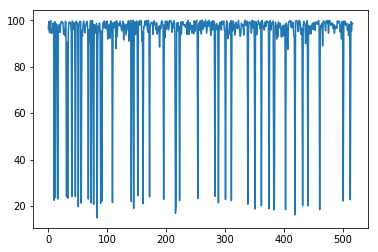

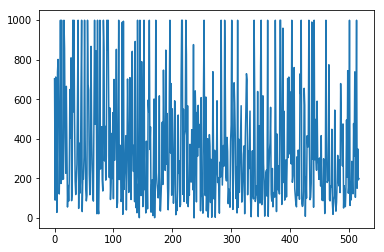

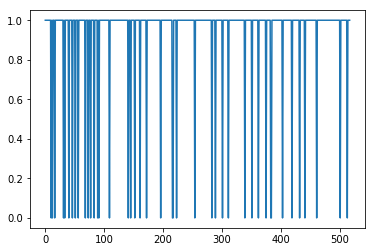

In [13]:
plt.plot(total_reward)
plt.figure()
plt.plot(total_length)
plt.figure()
plt.plot(total_captured)